# Solving book problems from Lehninger

## Chapter 14 problem 6
**Glycolysis Shortcut:** Suppose you discovered a mutant yeast whose glycolytic pathway was shorter because of the presence of a new enzyme catalyzing the reaction:

w/ metabolite names: `glyceraldehyde 3 phosphate + h2o + nad -> nadh + h + 2-phosphoglycerate`

w/ bigg ids: `g3p_c + h2o_c + nad_c -> nadh_c + h_c + 2pg_c`

**Approach**
1. Add reaction to core model
2. Plot maximum ATP production as a function of shortcut reaction activity


Text(0.5, 0, 'Shortcut flux')

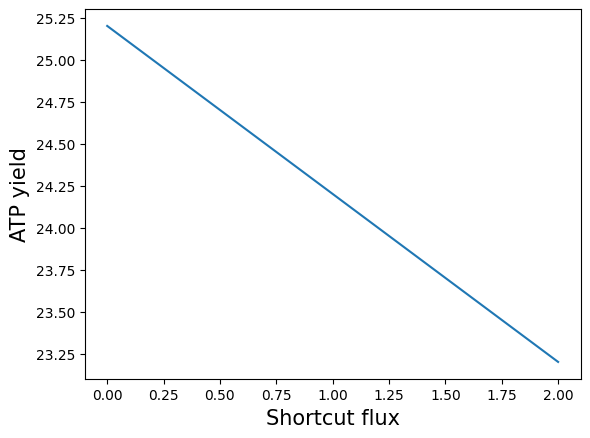

In [5]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import cobra

# Load Model
model_loc = list(Path('..').rglob('core_model.json'))[0]
model = cobra.io.load_json_model(model_loc)

# Add shortcut reaction
model.add_reactions([cobra.Reaction('shortcut')])
model.reactions.shortcut.build_reaction_from_string('g3p_c + h2o_c + nad_c -> nadh_c + h_c + 2pg_c')

# Assess ATP production ability
x = []
y = []
model.objective = 'ATPM'
for i in np.linspace(0, 2, 20): # Max flux through reaction is 2
    model.reactions.shortcut.lower_bound = i
    model.objective = 'ATPM'
    sol = model.optimize()
    x.append(i)
    y.append(sol.objective_value)
plt.plot(x, y)
plt.ylabel('ATP yield', size=15)
_ = plt.xlabel('Shortcut flux', size=15)

## Chapter 16 problem 23

**Net Synthesis of $\alpha$-Ketoglutarate:** $\alpha$-Ketoglutarate plays a central role in the biosynthesis of several amino acids. Write a sequence of enzymatic reactions that could result in the net synthesis of $\alpha$-ketoglutarate from pyruvate. Your proposed sequence must not involve the net consumption of other citric acid cycle intermediates. 

**Approach**
1. Simulate the synthesis of $\alpha$-ketoglutarate from pyruvate and display the solutions on a flux map
 - Use `cobra.flux_analysis.pfba` to ensure a parsimonious flux state

In [21]:
from pathlib import Path
import escher
import cobra
from matplotlib import pyplot as plt

map_loc = list(Path('..').rglob('core_map_v30.json'))[0]
model_loc = list(Path('..').rglob('core_model.json'))[0]

# Load Model
model = cobra.io.load_json_model(model_loc)

# add reaction for optimization
new_rxn = cobra.Reaction('DM_akg_m')
model.add_reactions([new_rxn])
new_rxn.add_metabolites({'akg_m': -1}) 

# set growth media
model.reactions.EX_pyr_c.lower_bound = -1
model.reactions.EX_glc__D_c.lower_bound = 0

# set objective and solve
model.objective = 'DM_akg_m'
sol = cobra.flux_analysis.pfba(model)

# display active reactions
filt = sol.to_frame()['fluxes'][abs(sol.to_frame()['fluxes']) > .1]
filt = filt.loc[[i for i in filt.index if  i[:3] not in ['DM_', 'EX_']]]
print('---------Reactions--------')
for i in filt.index:
    print(model.reactions.get_by_id(i))


builder = escher.Builder(map_json=str(map_loc), reaction_data=sol.to_frame()['fluxes'])
builder.reaction_scale = [
    {'type': 'value', 'color': 'red', 'size': 20, 'value': -0.01},
    {'type': 'value', 'color': 'grey', 'size': 0, 'value': 0},
    {'type': 'value', 'color': 'red', 'size': 20, 'value': 0.01}
]
builder

---------Reactions--------
CSm: accoa_m + h2o_m + oaa_m --> cit_m + coa_m + h_m
ACONTm: cit_m <=> icit_m
ICDHxm: icit_m + nad_m --> akg_m + co2_m + nadh_m
NADH2_u10mi: 5.0 h_m + nadh_m + q10_m --> 4.0 h_i + nad_m + q10h2_m
CYOR_u10mi: 2.0 ficytC_m + 2.0 h_m + q10h2_m --> 2.0 focytC_m + 4.0 h_i + q10_m
CYOOm2i: 4.0 focytC_m + 8.0 h_m + o2_m --> 4.0 ficytC_m + 2.0 h2o_m + 4.0 h_i
ATPS4mi: adp_m + 4.0 h_i + pi_m --> atp_m + h2o_m + 3.0 h_m
Htmi: h_i --> h_m
PDHm: coa_m + nad_m + pyr_m --> accoa_m + co2_m + nadh_m
PCm: atp_m + hco3_m + pyr_m --> adp_m + h_m + oaa_m + pi_m
HCO3Em: co2_m + h2o_m --> h_m + hco3_m
O2tm: o2_c <=> o2_m
H2Otm: h2o_c <=> h2o_m
CO2tm: co2_c <=> co2_m
PYRt2m: h_i + pyr_c --> h_m + pyr_m


Builder(reaction_data={'CSm': np.float64(0.5), 'ACONTm': np.float64(0.5), 'ICDHxm': np.float64(0.5), 'AKGDm': …

## Chapter 17 problem 8 (modified)

**$\beta$ Oxidation of Caprylic acid:** How many turns of the TCA cycle are required to fully oxidize the acetyl-CoA generated in $\beta$ oxidation of Caprylic acid? How many ATP can be generated from Caprylic acid

**Hint**: uptake for Caprylic acid is `EX_octa_c`

In [18]:
from pathlib import Path
import cobra
import escher

map_loc = list(Path('..').rglob('core_map_v30.json'))[0]
model_loc = list(Path('..').rglob('core_model.json'))[0]

# Load Model
model = cobra.io.load_json_model(model_loc)
model.reactions.EX_octa_c.lower_bound = -1
model.reactions.EX_glc__D_c.lower_bound = 0
sol = model.optimize()
print('Number of TCA cycle turns=', round(sol.fluxes['CSm'], 2))

builder = escher.Builder(map_json=str(map_loc), reaction_data=sol.to_frame()['fluxes'])
builder.reaction_scale = [
    {'type': 'value', 'color': 'red', 'size': 20, 'value': -0.01},
    {'type': 'value', 'color': 'grey', 'size': 0, 'value': 0},
    {'type': 'value', 'color': 'red', 'size': 20, 'value': 0.01}
]
builder

4.0


Builder(reaction_data={'CSm': np.float64(4.0), 'ACONTm': np.float64(4.0), 'ICDHxm': np.float64(4.0), 'AKGDm': …

---
## Chapter 19 problem 6 

**Uncouplers of ETC:** In normal mitochondria the rate of electron transfer is tightly coupled to the demand for ATP. When the rate of use of ATP is relatively low, the rate of electron transfer is low; when demand for ATP increases, electron-transfer rate increases. Under these conditions of tight coupling, the number of ATP molecules produced per atom of oxygen consumed when NADH is the electron donor—the P/O ratio—is about 2.5.

### Part A
Predict the effect of a relatively low and a relatively high concentration of uncoupling agent on the rate of electron transfer and the P/O ratio.

**Approach**
1. Set minimum glucose uptake rate to -1 $\frac{mmol}{gDW \cdot hr}$
2. Flux can be forced through the `Htmi` reaction to uncouple electron transport chain
3. P/O ratio can be computed as `flux_ATPS4mi / (flux_EX_o2_c * 2)`
4. Rate of electron transfer per ATP can be computed as `(flux_NADH2_u10mi + flux_FADH2ETC) / flux_ATPS4mi`
5. Plot bloth change of P/O ratio and rate of electron transfer per ATP as a function of uncouping (0 to 95%)
 - Optimize for Htmi to get the maximum upcoupling flux

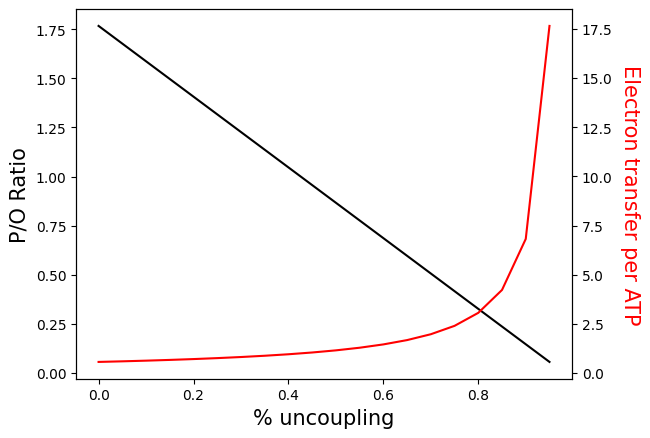

FileNotFoundError: [Errno 2] No such file or directory: 'core_model.json'

In [22]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import cobra

model_loc = list(Path('..').rglob('core_model.json'))[0]


model = cobra.io.load_json_model(model_loc)

x = []
y = []
y2=[]

# Find maximum uncoupling value possible
model.objective = 'Htmi'
sol = model.optimize()
max_uncoupling = sol.objective_value

# simulate from 0 to 95% uncoupled
for i in np.linspace(0, .95, 20):
    model.reactions.Htmi.lower_bound = i * max_uncoupling
    model.objective = 'ATPM'
    model.optimize()
    
    # append P/O ratio and electron transfer rate
    y.append(model.reactions.ATPS4mi.flux / abs((model.reactions.EX_o2_c.flux * 2)))
    y2.append((model.reactions.NADH2_u10mi.flux + model.reactions.FADH2ETC.flux) / model.reactions.ATPS4mi.flux)
    x.append(i)
    
# plot solutions
plt.plot(x, y, 'k')
plt.ylabel('P/O Ratio', fontdict={'color':'k', 'size': 15})
plt.xlabel('% uncoupling', size=15)
ax2 = plt.twinx()
ax2.plot(x, y2, c='r')
ax2.set_ylabel('Electron transfer per ATP',
               fontdict={'color':'r', 'size': 15}, rotation=-90, labelpad=20)
plt.show()
plt.close()



### Part B 

The uncoupler 2,4-dinitrophenol was once prescribed as a weight-reducing drug. How could this agent, in principle, serve as a weight-reducing aid? Uncoupling agents are no longer prescribed, because some deaths occurred following their use. Why might the ingestion of uncouplers lead to death?

**Approach**
Perform a similar analysis to the above, but now assuming there are additional energy reserves
1. With no uncoupling, find the maximum ATP production rate when the lower bound on glucose uptake rate is set to -1 $\frac{mmol}{gDW \cdot hr}$
 - This represents the basal ATP demand of the cell
 - Constrain ATPM to this flux value
2. Now allow up to -10 $\frac{mmol}{gDW \cdot hr}$ of glucose uptake
3. Repeat simulations from above, except with the objective of `EX_glc__D_e`
 - We want to find the minimum glucose uptake that can meet the basal ATP demand
4. Plot bloth change of P/O ratio and glucose uptake rate as a function of uncouping (0 to 95%)

In [ ]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import cobra

model_loc = list(Path('..').rglob('core_model.json'))[0]



model = cobra.io.load_json_model(model_loc)
x = []
y = []
y2=[]

# get ATPM value when glucose uptake is 1
sol_1 = model.optimize()
max_atpm = sol_1.fluxes['ATPM']
print('Max ATP production=', max_atpm)
model.reactions.ATPM.lower_bound = max_atpm

# get max Htmi
model.reactions.EX_glc__D_c.lower_bound = -10
model.objective = 'Htmi'
sol = model.optimize()
max_uncoupling = sol.objective_value

# simulate from 0 to 95% uncoupled
for i in np.linspace(0, .95, 20):
    model.reactions.Htmi.lower_bound = i * max_uncoupling 
    model.objective = 'EX_glc__D_c'
    model.optimize()
    
    # append P/O ratio and glucose uptake
    y.append(model.reactions.ATPS4mi.flux / abs((model.reactions.EX_o2_c.flux * 2)))
    y2.append(abs(model.reactions.EX_glc__D_c.flux))
    x.append(i)
    
# plot solutions
plt.plot(x, y, 'k')
plt.ylabel('P/O Ratio', fontdict={'color':'k', 'size': 15})
plt.xlabel('% uncoupling', size=15)
ax2 = plt.twinx()
ax2.plot(x, y2, c='r')

ax2.set_ylabel('Glucose Uptake', fontdict={'color':'r', 'size': 15}, rotation=-90, labelpad=20)
